# Importações

In [ ]:
import cv2
import os
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.image import random_flip_left_right, random_flip_up_down, random_brightness
from tensorflow.data.experimental import AUTOTUNE

from keras.callbacks import ModelCheckpoint
from keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Carregando os Dados

In [ ]:
# Conectando ao drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Caminho do dataset
data_dir = '/content/gdrive/MyDrive/Dog_Breeds_Classification/dog_breeds_dataset'

In [ ]:
# Quantidade de imagens por classe
for class_img in os.listdir(data_dir):
    img_class = 0
    for image in os.listdir(os.path.join(data_dir, class_img)):
        img_class += 1
    print(f'Number of images {class_img}: {img_class}')

Number of images golden_retriever: 305
Number of images chihuahua: 260
Number of images corgi: 262
Number of images german_shepherd: 350
Number of images beagle: 539
Number of images boxer: 255
Number of images pomeranian: 259
Number of images dachshund: 250
Number of images husky: 261
Number of images french_bulldog: 309
Number of images yorkshire_terrier: 285
Number of images shih_tzu: 471
Number of images shiba_inu: 230
Number of images poodle: 269
Number of images rottwiler: 473
Number of images pug: 258


In [ ]:
# Carregando o conjunto de dados com o tensorflow
data = image_dataset_from_directory(data_dir, seed=123,  image_size=(224, 224), label_mode= 'categorical')

Found 5035 files belonging to 16 classes.


In [ ]:
# Criando um numpy interator, para pegar lotes consecutivos do nosso conjunto de dados
data_iterator = data.as_numpy_iterator()

In [ ]:
# Acessando os lotes de dados
batch = data_iterator.next()

In [ ]:
# Imagens representadas como matrizes numpy
batch[0].shape

(32, 224, 224, 3)

In [ ]:
# Convertendo os rótulos codificados one-hot em seus equivalentes inteiros
def one_hot_to_integer(one_hot_labels):
    return np.argmax(one_hot_labels, axis=1)

# Classes dessas imagens
# class 0 = beagle
# class 1 = boxer
# class 2 = chihuahua
# class 3 = corgi
# class 4 = dachshund
# class 5 = french_bulldog
# class 6 = german_shepherd
# class 7 = golden_retriever
# class 8 = husky
# class 9 = pomeranian
# class 10 = poodle
# class 11 = pug
# class 12 = rottwiler
# class 13 = shiba_inu
# class 14 = shih_tzu
# class 15 = yorkshire_terrier

one_hot_to_integer(batch[1])

array([10,  6,  9, 12,  1,  4,  9,  1, 14,  3, 11,  8,  5,  0,  2, 10, 14,
       12,  2, 12,  3,  0, 14, 12,  7,  4,  5, 15, 14,  2, 10,  5])

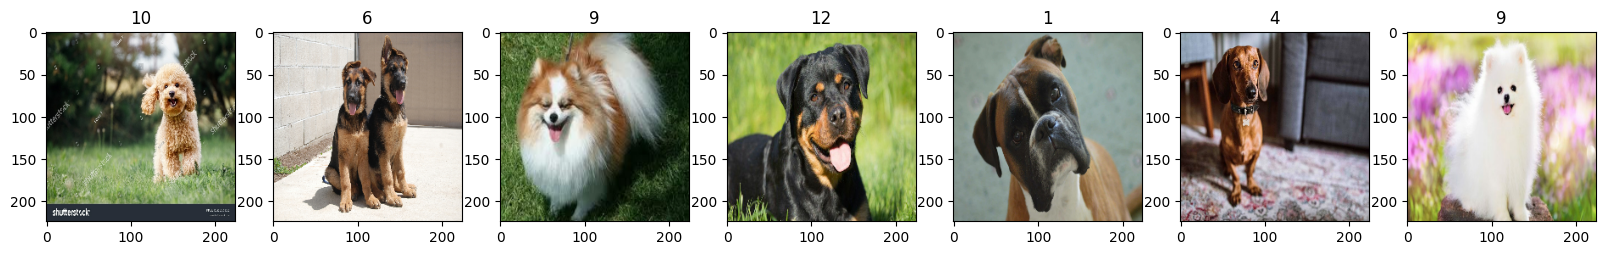

In [ ]:
# Apresentando algumas imagens do lote e seus rótulos
fig, ax = plt.subplots(ncols= 7, figsize= (20, 20))
for idx, img in enumerate(batch[0][0:7]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(one_hot_to_integer(batch[1])[idx])

# Pré Processamento dos Dados

In [ ]:
# Mudando a dimensão das imagens, para que fiquem com valores de 0 a 1
# Usando a função map para aplicar o redimensionamento em todo o conjunto de dados, e não apenas a um lote.
data = data.map(lambda x, y: (x/255, y))

In [ ]:
# min
data.as_numpy_iterator().next()[0].min()

0.0

In [ ]:
# max
data.as_numpy_iterator().next()[0].max()

1.0

In [ ]:
# Dividindo a base de dados
# data_size é o tamanha da base de dados em lotes
data_size = len(data)
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.25) + 1
test_size = int(len(data) * 0.15)

print(f'Data_size = {data_size}')
print(f'Train_size = {train_size} \nVal_size = {val_size} \nTest_size = {test_size}')

Data_size = 158
Train_size = 94 
Val_size = 40 
Test_size = 23


In [ ]:
# Com base nos tamanhos definidos alocamos esses lotes da nossa base de dados através da função take e skip
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [ ]:
# função para aumentar a variedade de dados de treinamento e melhorar a generalização do modelo
def data_augmentation(image, label):
    image = random_flip_left_right(image)
    image = random_flip_up_down(image)
    image = random_brightness(image, max_delta=0.2)
    return image, label

# aplicando data augmentation ao conjunto de treinamento
augmented = train.map(data_augmentation)
train = train.concatenate(augmented)

# Aplicando um Modelo de aprendizagem profunda

## Modelo

In [ ]:
# Modelo pré-treinado
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inceptionv3.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# Adicionando a nossa própria camada no final para classificação das 16 classes
model = Sequential()

model.add(inceptionv3)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='softmax'))

In [ ]:
model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['categorical_accuracy'])

## Treinando o modelo

In [ ]:
checkpoint = ModelCheckpoint(
    filepath = 'model.keras',
    monitor ='val_categorical_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)

In [ ]:
history = model.fit(train, epochs= 30, validation_data= val)

Epoch 1/30
188/188 [==============================] - 1306s 7s/step - loss: 1.6709 - categorical_accuracy: 0.7532 - val_loss: 0.3725 - val_categorical_accuracy: 0.9039
Epoch 2/30
188/188 [==============================] - 183s 958ms/step - loss: 0.7457 - categorical_accuracy: 0.7936 - val_loss: 0.2689 - val_categorical_accuracy: 0.9344
Epoch 3/30
188/188 [==============================] - 192s 997ms/step - loss: 0.6566 - categorical_accuracy: 0.8196 - val_loss: 0.2578 - val_categorical_accuracy: 0.9422
Epoch 4/30
188/188 [==============================] - 184s 962ms/step - loss: 0.5615 - categorical_accuracy: 0.8373 - val_loss: 0.2599 - val_categorical_accuracy: 0.9516
Epoch 5/30
188/188 [==============================] - 183s 955ms/step - loss: 0.5010 - categorical_accuracy: 0.8496 - val_loss: 0.3605 - val_categorical_accuracy: 0.9125
Epoch 6/30
188/188 [==============================] - 173s 908ms/step - loss: 0.5495 - categorical_accuracy: 0.8467 - val_loss: 0.3105 - val_categorical

In [ ]:
training_accuracy = max(history.history['categorical_accuracy'])
val_accuracy = max(history.history['val_categorical_accuracy'])

print(f'Training Accuracy : {training_accuracy}')
print(f'Validation Accuracy : {val_accuracy}')

Training Accuracy : 0.9286901354789734
Validation Accuracy : 0.965624988079071


## Resultados do modelo

In [ ]:
# Calculando a precisão, recall e acurácia em todos os lotes da base de dados de treino
y_pred_all = []
y_all = []

for batch in test.as_numpy_iterator():
  X, y = batch

  y = np.argmax(y, axis=1)
  y_pred = model.predict(X)
  y_pred = np.argmax(y_pred, axis=1)

  y_pred_all.extend(y_pred)
  y_all.extend(y)

1/1 [==============================] - 0s 33ms/step


In [ ]:
print(accuracy_score(y_pred_all, y_all))

0.9524456521739131


In [ ]:
print(classification_report(y_pred_all, y_all))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      1.00      0.99        34
           2       0.91      0.78      0.84        41
           3       0.91      0.97      0.94        31
           4       0.91      0.95      0.93        42
           5       0.90      1.00      0.95        37
           6       0.94      1.00      0.97        49
           7       1.00      0.87      0.93        47
           8       0.92      0.95      0.94        38
           9       0.97      0.97      0.97        34
          10       1.00      0.96      0.98        48
          11       0.98      0.93      0.95        45
          12       0.99      0.97      0.98        70
          13       0.81      0.89      0.85        28
          14       0.97      1.00      0.99        70
          15       1.00      0.94      0.97        50

    accuracy                           0.95       736
   macro avg       0.95   

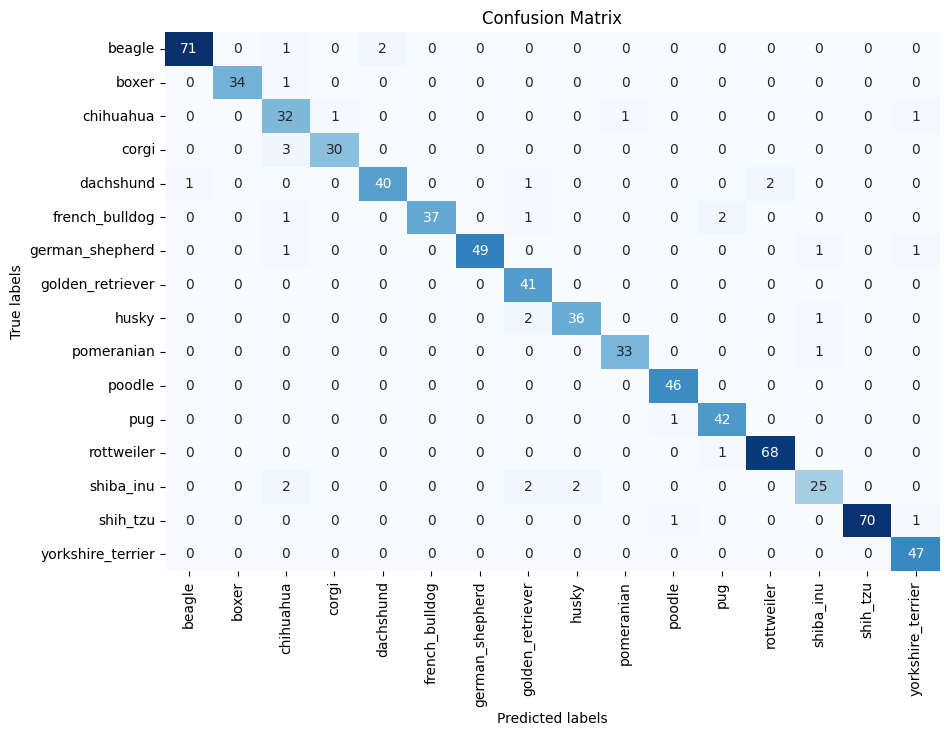

In [ ]:
# Plotando a matriz de confusão
class_names = ["beagle", "boxer", "chihuahua", "corgi", "dachshund", "french_bulldog", "german_shepherd",
                "golden_retriever", "husky", "pomeranian", "poodle", "pug", "rottweiler", "shiba_inu", "shih_tzu", "yorkshire_terrier"]

matriz = confusion_matrix(y_all, y_pred_all, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

plt.figure(figsize=(10, 7))
sns.heatmap(matriz, annot=True, fmt='g', cbar=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Salvando o modelo

In [ ]:
model.save(os.path.join("/content/gdrive/MyDrive/Dog_Breeds_Classification/model", "best_model.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
